SIN-392 - Introdução ao Processamento Digital de Imagens (2023-1)

# Aula 15 - Classificação de imagens

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---

## Importando as bibliotecas
---

In [1]:
import os

import numpy as np
from skimage import util, transform, filters, color, measure, morphology
from sklearn import model_selection, neighbors, metrics, preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### %matplotlib notebook
### %matplotlib widget

## O conjunto de dados (dataset)
---
* Flavia leaf dataset:
    * Um dataset contendo imagens de folhas
    * http://flavia.sourceforge.net/ 
    * 1,907 imagens
    * 33 classes

### Versão reduzida do Flavia dataset

* Only 3 of the 33 classes (all images in these classes)
    * ```data/flavia```
* Only 6 images in each of the 3 classes
    * ```data/flavia_toy```

In [2]:
# 3 classes - all images in these classes
ds_path = 'data/flavia_toy'

# 3 classes - 6 images per class
#### ds_path = 'data/flavia_toy2'

In [3]:
print(ds_path)

data/flavia_toy


## Carregando as imagens do dataset

In [4]:
# List of all folders in the folder 'ds_path' (classes)
classes_list = os.listdir(ds_path)

# List of all images in the dataset
image_list = []
# Lista of the image labels
label_list = []

# List of the image names
filename_list_ = []

# Iterate along the classes of the dataset
for classe in classes_list:
    
    # List of all images in the folder for this class
    filename_list = os.listdir(os.path.join(ds_path, classe))

    filename_list.sort()
    
    # Iterate along the files in the current folder
    for filename in filename_list:
        # Load the image
        img_temp = plt.imread(os.path.join(ds_path, classe, filename))
        
        # Redimensiona a imagem para 1/4 do tamanho original
        img_temp = transform.resize(img_temp, (img_temp.shape[0]//4, img_temp.shape[1]//4), anti_aliasing=True)
        
        # Append the image to a list
        image_list.append(img_temp)
        # Append the label to a list
        label_list.append(classe)
        # Append the file name to a list (for visualization purposes)
        filename_list_.append(filename)

# Convert list to NumPy array
label_list = np.array(label_list)

# List with the image labels.        
print(label_list)

['acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'aesculus_chinensis' 'aesculus_chinensis' 'aesculus_chinensis'
 'aesculus_chinensis' 'aes

### Plotando as imagens do dataset

* Plotting the N first images for each class.
* Important to start understanding the dataset.

In [5]:
# Select the first N images from each class.
N = 6
image_list_temp = []
filename_list_temp = []

# Iterate along the classes
for i in range(3):
    # As N primeiras ocorrencias em que label é igual a 'i'.
    image_list_temp += [image_list[j] for j in np.where(label_list==classes_list[i])[0][:N]]
    filename_list_temp += [filename_list_[j] for j in np.where(label_list==classes_list[i])[0][:N]]

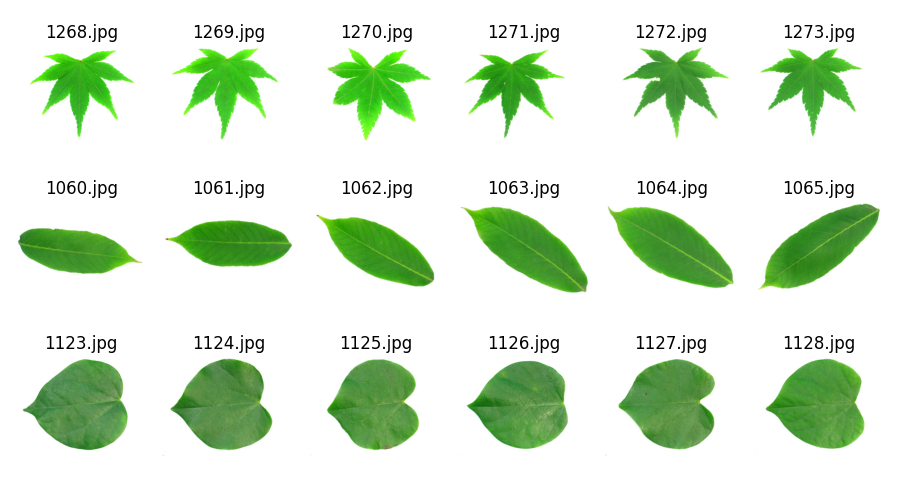

In [6]:
fig, ax  = plt.subplots(3, 6, figsize=(9, 5))

for i, (image, filename) in enumerate(zip(image_list_temp, filename_list_temp)):
    ax[i//6, i%6].imshow(image, vmin=0, vmax=255)
    ax[i//6, i%6].set_title(str(filename))
    ax[i//6, i%6].axis('off')

fig.tight_layout()
plt.show()

## Extracting some features from images
----
* Vamos extrair algumas caracteristicas de forma dos objetos nas imagens.
    * Área, maior eixo, menor eixo, solidez e ecentricidade.
* Para isso, primeiramente é necessário segmentar as folhas presentes na imagem.
    1. Converter o tipo de dados da imagem para float;
    2. Converter a imagem de RGB para níveis de cinza;
    3. Segmentar a imagem usando o método de Otsu;
    4. Remover artefatos resultantes da segmentação com tamanho menor do que 10.000 pixels.

In [7]:
# Nomes das caracteristicas computadas
features = ['area', 'major_axis', 'minor_axis', 'solidity', 'eccentricity']

In [8]:
# 2D array with the images features
# Each line stores information about an image. Each column stores one feature.
# [ [area, major_axis, minor_axis, solidity, eccentricity] ]
feature_mat = []

# Lista com as imagens segmentadas (binárias)
seg_list = []
# Lista com os rótulos das imagens
list_label = []

for i, (image, label) in enumerate(zip(image_list, label_list)):
    ### print('Imagem {} - classe {}'.format(i, label))
    
    # Adiciona o rótulos (label) da imagem à lista
    list_label.append(label)
    
    # Image segmentation
    # --------------------------------------------------
    # Convert the image data type to float
    img_float = util.img_as_float(image)
    ### print(img_float.shape, img_float.min(), img_float.max())
    
    # Convert to intensity image (gray level)
    img_float = color.rgb2gray(img_float)
    
    # Segmentação por limiarização usando Otsu
    img_seg = img_float < filters.threshold_otsu(img_float)
    ### print(img_seg.shape, img_seg.min(), img_seg.max())
    
    # Remove objetos na imagem com menos de N pixels.
    img_seg = morphology.remove_small_objects(img_seg, 10000)
    
    # Append the segmented image to a list
    seg_list.append(img_seg)
    
    # Generate a label image
    im_lbl = measure.label(img_seg)
    
    # Calcula uma lista de propriedades (caracteristicas) dos objetos na imagem
    props = measure.regionprops(im_lbl)
    ### print(len(props))
    
    if len(props) != 1:
        print(f'Segmentation ERROR: {len(props)}')
        continue

    # Iterate along the computed feartures
    for prop in props:
        # Prop. 0: Area
        area = prop.area
        # Prop. 1: Maior eixo
        major_axis = prop.major_axis_length
        # Prop. 2: Menor eixo
        minor_axis = prop.minor_axis_length 
        # Prop. 3: Solidez
        solidity = prop.solidity 
        # Prop. 4: Excentricidade
        eccentricity = prop.eccentricity 

        # Monta o vetor de caracteristicas deste objeto.
        feature_list = [area, major_axis, minor_axis, solidity, eccentricity]
    
    # Adiciona as caracteristicas desta imagem na matriz de caracteristicas
    feature_mat.append(feature_list)

In [9]:
# Converte a lista de caracteristicas para um arranjo NumPy
feature_mat = np.array(feature_mat)

# Shape of the feature_mat.
# Each row is a sample (image), and each column is a feature.
print(feature_mat.shape)

(191, 5)


In [10]:
# Algumas estatisticas sobre o conjunto de caracteristicas
with np.printoptions(precision=4, suppress=True):
    print(feature_mat.min(0))
    print(feature_mat.max(0))
    print(feature_mat.mean(0))
    print(feature_mat.std(0))

[17632.       186.1457   115.8967     0.4389     0.0952]
[62852.       414.4433   273.5043     0.9846     0.9333]
[42335.4555   290.3434   203.0027     0.8368     0.5644]
[11898.8393    63.574     44.8523     0.2023     0.2619]


### Plotting some segmented images from each class
* Plotando um subconjunto de imagens segmentadas de cada classe

In [11]:
# Seleciona apenas as primeiras N imagens de cada classe
seg_list_temp = []
filename_list_temp = []

# Itera pelo número de classes
for i in range(3):
    # As 6 primeiras ocorrencias em que label é igual a 'i'.
    seg_list_temp += [seg_list[j] for j in np.where(label_list==classes_list[i])[0][:6]]
    filename_list_temp += [filename_list_[j] for j in np.where(label_list==classes_list[i])[0][:6]]

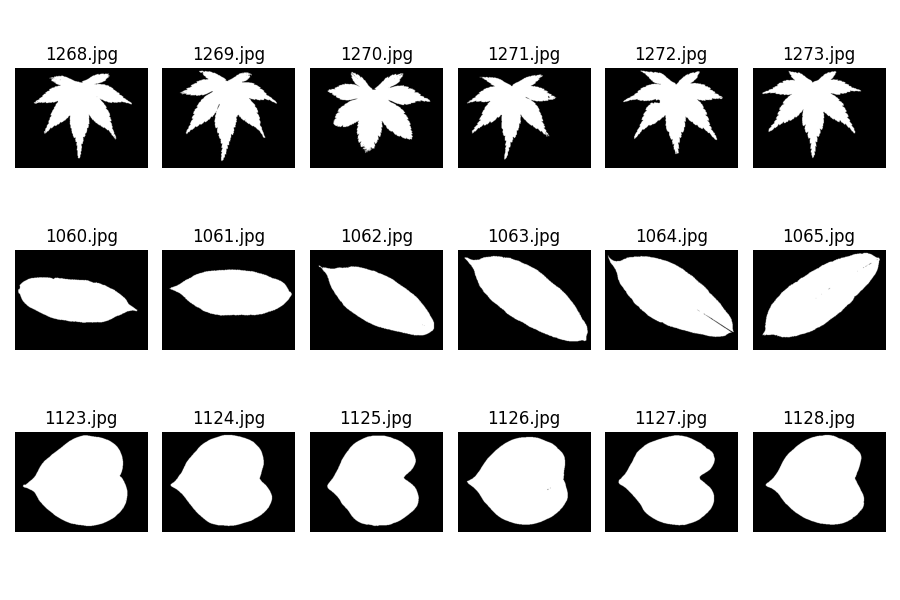

In [12]:
fig, ax  = plt.subplots(3, 6, figsize=(9, 6))

for i, (image, filename) in enumerate(zip(seg_list_temp, filename_list_temp)):
    ax[i//6, i%6].imshow(image, cmap='gray')
    ax[i//6, i%6].set_title(str(filename))
    ax[i//6, i%6].axis('off')
    
fig.tight_layout()
plt.show()

### Plotando as caracteristicas computadas

In [13]:
df = pd.DataFrame(feature_mat, columns=features)

df['class'] = label_list

### print(df)
display(df)

,area,major_axis,minor_axis,solidity,eccentricity,class
0,29335.0,232.175652,199.506366,0.555829,0.511488,acer_palmatum
1,30990.0,233.525495,212.554472,0.545685,0.414173,acer_palmatum
2,35396.0,258.027906,208.486083,0.653135,0.589185,acer_palmatum
3,27018.0,223.482678,195.044617,0.524581,0.488167,acer_palmatum
4,30928.0,244.160662,203.943848,0.525700,0.549817,acer_palmatum
...,...,...,...,...,...,...
186,52762.0,275.851396,249.959329,0.959693,0.422983,cersis_chinensis
187,55364.0,278.685695,255.949680,0.969105,0.395614,cersis_chinensis
188,50414.0,278.638768,236.241707,0.955716,0.530249,cersis_chinensis
189,51698.0,271.726867,246.742366,0.964983,0.418856,cersis_chinensis


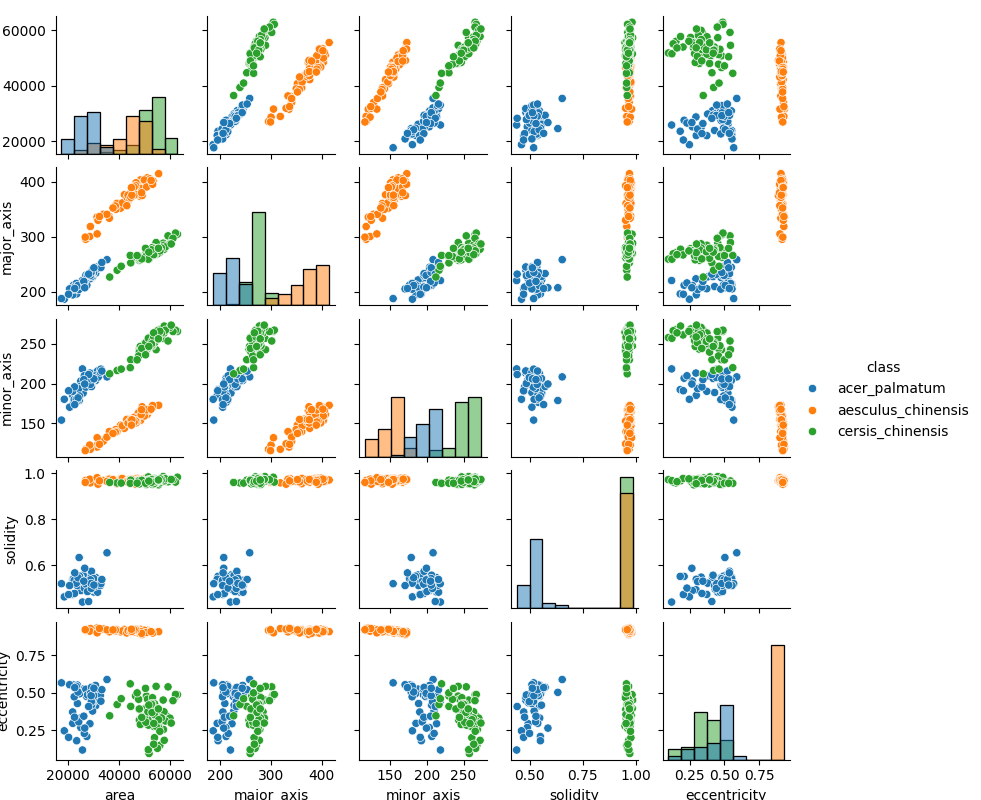

In [14]:
g = sns.PairGrid(df, hue='class', vars=features)
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## Cross-validation - Hold-out
---

* Separa o conjunto de dados em subconjuntos para treino, validação e testes. 
    * Neste exemplo, por motivos de simplificação, vamos dividir apenas em treino e testes.

In [15]:
# Selecionamos apenas duas caracteristicas: Área e maior-eixo
feature_mat_ok = feature_mat[:,0:2]

In [16]:
# Separa o conjunto de dados em 'feature_mat_ok', de acordo com 'label_list'. 
# 30% das imagens vão para o conjunto de testes.
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_mat_ok, 
                                                                    label_list, 
                                                                    test_size=0.3, 
                                                                    random_state=42)

In [17]:
print(len(X_train))
print(len(X_test))

133
58


### Feature normalization

* As características obtidas podem apresentar faixas de valores muito diferentes. 
    * Isso pode dificultar o treinamento do modelo. 
    * Neste exemplo, a faixa de valores da 'area' vai de 17.644 até 62.862, aproximadamente, já a faixa de valores da circularidade vai de 0,0 até 1,0.
* A normalização transforma as características de forma que elas estejam em faixas de valores equivalentes. 
* A ```transformada normal de características``` ou ```Standard Scaler``` consiste em subtrair a média do conjunto de dados e, em seguida, dividir pelo desvio padrão. 
    * A transformada normal de características gera um conjunto de dados com média 0 e desvio padrão 1.
* A normalização **não** deve ser realizada sobre todo o conjunto de dados. 
    * A normalização deve ser realizada **após** a divisão do conjunto para a validação cruzada.
    * O conjunto de testes não deve ser acessado, nem direta nem indiretamente, durante o treinamento ou durante o ajuste de hiperparâmetros. 
    * A normalização do conjunto de treinamento, de validação e de testes deve ser realizado usando a média e o desvio padrão do conjunto de treinamento.

In [18]:
# Média das caracteristicas do conjunto de treinamento
X_train_mean = X_train.mean(0)
# Desvio padrão das caracteristicas do conjunto de treinamento
X_train_std = X_train.std(0)

with np.printoptions(precision=4, suppress=True):
    print(X_train.mean(0))
    print(X_train.std(0))

[41870.8496   288.7018]
[11396.789    61.97 ]


In [19]:
# Transformada Normal de Caracteristicas
X_train_norm = (X_train - X_train_mean) / X_train_std
X_test_norm = (X_test - X_train_mean) / X_train_std

with np.printoptions(precision=4, suppress=True):
    print(X_train_norm.mean(0))
    print(X_test_norm.mean(0))
    print(X_train_norm.std(0))
    print(X_test_norm.std(0))    

[-0. -0.]
[0.1342 0.0872]
[1. 1.]
[1.1331 1.0805]


### Classifying using K-nearest neighbors


In [20]:
# Constrói um classificador do tipo K-NN
# K = 3
clf = neighbors.KNeighborsClassifier(n_neighbors=3)

# Treinando o classificador
clf.fit(X_train_norm, y_train)

# Testando o classificador
pred = clf.predict(X_test_norm)

### Evaluating the model


In [21]:
# Acertos
acertos = y_test == pred

print('\n Predição:')
print(pred)
print('\nReal:')
print(y_test)
print('\nAcerto/Erro:')
print(acertos.astype(int))


 Predição:
['cersis_chinensis' 'aesculus_chinensis' 'cersis_chinensis'
 'aesculus_chinensis' 'aesculus_chinensis' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'cersis_chinensis' 'cersis_chinensis' 'cersis_chinensis'
 'cersis_chinensis' 'acer_palmatum' 'cersis_chinensis'
 'aesculus_chinensis' 'cersis_chinensis' 'cersis_chinensis'
 'aesculus_chinensis' 'cersis_chinensis' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'aesculus_chinensis' 'aesculus_chinensis'
 'aesculus_chinensis' 'aesculus_chinensis' 'aesculus_chinensis'
 'acer_palmatum' 'acer_palmatum' 'aesculus_chinensis' 'cersis_chinensis'
 'aesculus_chinensis' 'acer_palmatum' 'cersis_chinensis'
 'aesculus_chinensis' 'cersis_chinensis' 'aesculus_chinensis'
 'cersis_chinensis' 'cersis_chinensis' 'acer_palmatum'
 'aesculus_chinensis' 'acer_palmatum' 'cersis_chinensis'
 'aesculus_chinensis' 'aesculus_chinensis' 'acer_palmatum'
 'cersis_chinensis' 'acer_palmatum' 'cersis_chinensis' 'cersis_chinensis'
 'acer_palmatum' 'cersis_chinen

#### Confusion matrix and classification report

In [22]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_test, pred))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_test, pred))


Matriz de confusão:
[[17  0  0]
 [ 0 19  0]
 [ 0  0 22]]

Relatório de classificação:
                    precision    recall  f1-score   support

     acer_palmatum       1.00      1.00      1.00        17
aesculus_chinensis       1.00      1.00      1.00        19
  cersis_chinensis       1.00      1.00      1.00        22

          accuracy                           1.00        58
         macro avg       1.00      1.00      1.00        58
      weighted avg       1.00      1.00      1.00        58



## Bibliografia
---
* GONZALEZ, R.C.; WOODS, R.E.; Processamento Digital de Imagens. 3ª edição. Editora Pearson, 2009.
* COSTA, L. DA F.; CESAR-JR., R. M. Shape analysis and classification: theory and practice. CRC Press, 2000. Chapter 8.
* Scikit-image documentation.
    * https://scikit-image.org/docs/stable/
* scikit-learn - User Guide.
    * https://scikit-learn.org/stable/user_guide.html